## Step 1: Import Libraries and Setup

In [1]:
import torch
import torch.nn as nn
import numpy as np
from collections import Counter

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.7.1+cu126
CUDA available: True


## Step 2: Prepare  Sentences

In [2]:
# Our training data: funny sentences!
sentences = [
    "Why did the chicken cross the road",
    "A chicken crossed the road",
    "The chicken is very funny",
    "I like funny chickens and ducks",
    "Ducks are funny animals",
    "Why do chickens tell jokes",
    "The road is long and funny",
    "Chickens and ducks tell funny stories",
    "A funny duck crossed the road",
    "I love funny animals and jokes",
]

print("Our Sentences:")
for i, sentence in enumerate(sentences, 1):
    print(f"{i:2}. {sentence}")

Our Sentences:
 1. Why did the chicken cross the road
 2. A chicken crossed the road
 3. The chicken is very funny
 4. I like funny chickens and ducks
 5. Ducks are funny animals
 6. Why do chickens tell jokes
 7. The road is long and funny
 8. Chickens and ducks tell funny stories
 9. A funny duck crossed the road
10. I love funny animals and jokes


## Step 3: Build a Vocabulary

In [3]:
# Step 1: Tokenize (split into words) and build vocabulary
def build_vocab(sentences):
    """Build a vocabulary from sentences."""
    words = []
    for sentence in sentences:
        words.extend(sentence.lower().split())

    # Create word-to-index and index-to-word mappings
    unique_words = sorted(list(set(words)))
    word2idx = {word: idx for idx, word in enumerate(unique_words)}
    idx2word = {idx: word for word, idx in word2idx.items()}

    return word2idx, idx2word, unique_words


word2idx, idx2word, unique_words = build_vocab(sentences)

print(f"Vocabulary size: {len(unique_words)}")
print(f"Word to Index mapping (first 10):")
for word, idx in list(word2idx.items())[:10]:
    print(f"  {word:10} -> {idx}")
print(f"Total unique words: {len(word2idx)}")

Vocabulary size: 25
Word to Index mapping (first 10):
  a          -> 0
  and        -> 1
  animals    -> 2
  are        -> 3
  chicken    -> 4
  chickens   -> 5
  cross      -> 6
  crossed    -> 7
  did        -> 8
  do         -> 9
Total unique words: 25


## Step 4: Create an Embedding Layer

In [9]:
# Define embedding parameters
vocab_size = len(word2idx)
embedding_dim = 3  # Size of each word embedding (usually 50, 100, 300, etc.)

# Create an embedding layer
embedding_layer = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)

print(f"Embedding layer created!")
print(f"  Vocabulary size: {vocab_size}")
print(f"  Embedding dimension: {embedding_dim}")
print(f"  Total parameters: {vocab_size * embedding_dim}")

# Let's check the weights
print(f"\nEmbedding weights shape: {embedding_layer.weight.shape}")

Embedding layer created!
  Vocabulary size: 25
  Embedding dimension: 3
  Total parameters: 75

Embedding weights shape: torch.Size([25, 3])


## Step 5: Convert Sentences to Indices and Get Embeddings

In [11]:
def sentence_to_indices(sentence, word2idx):
    """Convert a sentence to indices."""
    words = sentence.lower().split()
    indices = [word2idx[word] for word in words]
    return torch.tensor(indices)


# Convert our sentences to embeddings
print("Converting sentences to embeddings:\n")

sentence_embeddings = {}
for sentence in sentences[:3]:  # Show first 3 sentences
    # Convert sentence to indices
    indices = sentence_to_indices(sentence, word2idx)

    # Get embeddings
    embeddings = embedding_layer(indices)
    sentence_embeddings[sentence] = embeddings

    print(f"Sentence: '{sentence}'")
    print(f"Indices: {indices.tolist()}")
    print(f"Embeddings shape: {embeddings.shape}")
    print(f"Embeddings:\n{embeddings}")
    print("-" * 70)

Converting sentences to embeddings:

Sentence: 'Why did the chicken cross the road'
Indices: [24, 8, 22, 4, 6, 22, 19]
Embeddings shape: torch.Size([7, 3])
Embeddings:
tensor([[ 0.1210,  0.5535, -1.9203],
        [-0.0200, -1.2131,  1.1971],
        [ 0.0784,  0.3892,  0.3429],
        [ 1.6077, -0.8064,  0.0732],
        [ 1.0366,  0.8817, -1.3237],
        [ 0.0784,  0.3892,  0.3429],
        [ 1.2538, -0.6843,  2.0921]], grad_fn=<EmbeddingBackward0>)
----------------------------------------------------------------------
Sentence: 'A chicken crossed the road'
Indices: [0, 4, 7, 22, 19]
Embeddings shape: torch.Size([5, 3])
Embeddings:
tensor([[-0.9437,  0.1730, -1.8815],
        [ 1.6077, -0.8064,  0.0732],
        [-0.3675,  1.0117, -1.4080],
        [ 0.0784,  0.3892,  0.3429],
        [ 1.2538, -0.6843,  2.0921]], grad_fn=<EmbeddingBackward0>)
----------------------------------------------------------------------
Sentence: 'The chicken is very funny'
Indices: [22, 4, 14, 23, 12]
Em

## Step 6: Explore Individual Word Embeddings

In [16]:
# Let's look at embeddings for specific words
interesting_words = ["chicken", "duck", "funny", "road", "the"]

print("Word Embeddings:")
print("=" * 70)

for word in interesting_words:
    if word in word2idx:
        word_idx = word2idx[word]
        word_embedding = embedding_layer.weight[word_idx]
        print(f"Word: '{word}' (index {word_idx})")
        print(f"Embedding: {word_embedding.detach().numpy()} \n")

Word Embeddings:
Word: 'chicken' (index 4)
Embedding: [ 1.6076998  -0.80642855  0.0732011 ] 

Word: 'duck' (index 10)
Embedding: [0.29770067 0.7592252  1.9490781 ] 

Word: 'funny' (index 12)
Embedding: [-0.787175    2.4992015  -0.30195442] 

Word: 'road' (index 19)
Embedding: [ 1.253806   -0.68434024  2.0921295 ] 

Word: 'the' (index 22)
Embedding: [0.0783911  0.3891608  0.34287506] 



## Step 7: Calculate Similarity Between Words

In [17]:
def cosine_similarity(vec1, vec2):
    """Calculate cosine similarity between two vectors."""
    dot_product = torch.dot(vec1, vec2)
    norm1 = torch.norm(vec1)
    norm2 = torch.norm(vec2)
    return (dot_product / (norm1 * norm2)).item()


# Calculate similarity between word pairs
word_pairs = [
    ("chicken", "duck"),
    ("chicken", "funny"),
    ("chicken", "road"),
    ("funny", "joke"),
    ("road", "journey"),
    ("the", "and"),
]

print("Word Pair Similarities (using Cosine Similarity):")
print("=" * 50)

for word1, word2 in word_pairs:
    if word1 in word2idx and word2 in word2idx:
        vec1 = embedding_layer.weight[word2idx[word1]]
        vec2 = embedding_layer.weight[word2idx[word2]]
        similarity = cosine_similarity(vec1, vec2)
        print(f"'{word1}' <-> '{word2}': {similarity:.4f}")
    else:
        print(f"'{word1}' <-> '{word2}': (word not in vocabulary)")

Word Pair Similarities (using Cosine Similarity):
'chicken' <-> 'duck': 0.0024
'chicken' <-> 'funny': -0.6957
'chicken' <-> 'road': 0.5966
'funny' <-> 'joke': (word not in vocabulary)
'road' <-> 'journey': (word not in vocabulary)
'the' <-> 'and': 0.3249


## Step 8: Visualize Embeddings (2D Projection)

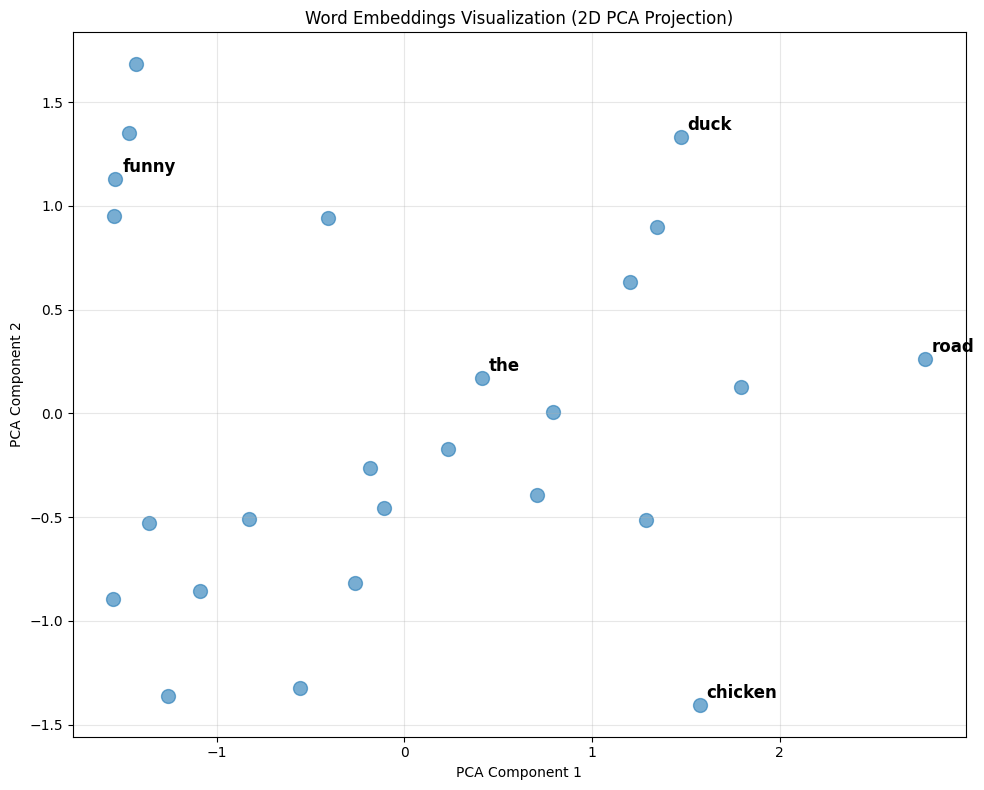

Explained variance: [0.520588   0.26456296]


In [18]:
# Try installing matplotlib if not available
import matplotlib.pyplot as plt

# Project embeddings to 2D using PCA (simple version)
from sklearn.decomposition import PCA

# Get all word embeddings
all_embeddings = embedding_layer.weight.detach().numpy()

# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(all_embeddings)

# Plot
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.6, s=100)

# Add labels for interesting words
for word in interesting_words:
    if word in word2idx:
        idx = word2idx[word]
        plt.annotate(
            word,
            xy=(embeddings_2d[idx, 0], embeddings_2d[idx, 1]),
            xytext=(5, 5),
            textcoords="offset points",
            fontsize=12,
            fontweight="bold",
        )

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Word Embeddings Visualization (2D PCA Projection)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Explained variance: {pca.explained_variance_ratio_}")

## Step 9: Average Embeddings for Sentences

In [19]:
def get_sentence_embedding(sentence, embedding_layer, word2idx):
    """Get an embedding for an entire sentence by averaging word embeddings."""
    indices = sentence_to_indices(sentence, word2idx)
    word_embeddings = embedding_layer(indices)
    # Average the embeddings
    sentence_embedding = word_embeddings.mean(dim=0)
    return sentence_embedding


# Get embeddings for our funny sentences
print("Sentence Embeddings (averaged word embeddings):")
print("=" * 70)

sentence_embeddings_list = []
for sentence in sentences:
    sent_emb = get_sentence_embedding(sentence, embedding_layer, word2idx)
    sentence_embeddings_list.append((sentence, sent_emb))
    print(f"\nSentence: '{sentence}'")
    print(f"Embedding: {sent_emb.detach().numpy()}")

Sentence Embeddings (averaged word embeddings):

Sentence: 'Why did the chicken cross the road'
Embedding: [ 0.59370655 -0.07004882  0.11487629]

Sentence: 'A chicken crossed the road'
Embedding: [ 0.3257388   0.01663705 -0.15625045]

Sentence: 'The chicken is very funny'
Embedding: [-0.22648568  0.0835155  -0.11319369]

Sentence: 'I like funny chickens and ducks'
Embedding: [-0.66942596  1.205894    0.2175215 ]

Sentence: 'Ducks are funny animals'
Embedding: [0.23051994 0.8329821  0.3218305 ]

Sentence: 'Why do chickens tell jokes'
Embedding: [-0.5111481   0.62014526 -0.39741033]

Sentence: 'The road is long and funny'
Embedding: [-0.13803779  0.868887    0.03771274]

Sentence: 'Chickens and ducks tell funny stories'
Embedding: [-0.26208195  0.9293379   0.15475118]

Sentence: 'A funny duck crossed the road'
Embedding: [-0.07808002  0.69134     0.13211173]

Sentence: 'I love funny animals and jokes'
Embedding: [ 0.07728542  0.6885399  -0.31390914]


---

## Key Takeaways 🎯

### What You Learned:

1. **Embeddings** are dense vector representations of words that capture semantic meaning
2. **nn.Embedding** layer converts integer indices to embedding vectors
3. **Vocabulary** is essential - we need to map words to indices
4. **Similarity** can be measured using cosine distance between embeddings
5. **Sentence embeddings** can be created by averaging word embeddings
6. **Embeddings are learnable** - they're trained as part of the model

### Why Embeddings Matter:

- **Compact representation**: Instead of one-hot encoding (huge sparse vectors), embeddings are small and dense
- **Semantic relationships**: Similar words have similar embeddings
- **Transfer learning**: Pre-trained embeddings (like Word2Vec, GloVe, FastText) can be used for various tasks
- **Foundation for NLP**: Embeddings are the foundation for transformers, language models, and modern NLP

### Next Steps:

- Try different embedding dimensions (8, 16, 32, 64, 128, 300)
- Use pre-trained embeddings (GloVe, FastText)
- Build more complex models (LSTMs, Transformers) on top of embeddings
- Explore word analogies: "king" - "man" + "woman" ≈ "queen"

---

## Bonus: Fun Exercises 🎮

Try these exercises to deepen your understanding:

### Exercise 1: Experiment with Embedding Dimensions
```python
# Create embeddings with different dimensions and compare similarities
for dim in [2, 4, 8, 16, 32]:
    emb = nn.Embedding(vocab_size, dim)
    # Calculate similarities...
```

### Exercise 2: Create Your Own Funny Sentences
```python
# Add more funny sentences and rebuild the vocabulary
funny_sentences.extend([
    "Why does the duck tell jokes",
    "The chicken and duck are friends"
])
```

### Exercise 3: Implement Word Analogies
```python
# Implement: word1 - word2 + word3 = ?
# E.g., "chicken" - "funny" + "duck" ≈ ?
```

### Exercise 4: Visualize Embeddings
```python
# Try t-SNE or UMAP instead of PCA
from sklearn.manifold import TSNE
```

Happy learning! 🚀